### Importing packages

In [73]:
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy.stats import norm

### Defining functions for Monte Carlo Simulations

In [256]:
def underlyingPriceSimulation(S0, r, sigma, T, Nt, Nsim):
    
    dt = T/Nt
    paths = np.zeros((Nsim, Nt+1))
    paths[:,0] = S0
    for i in range(1, Nt+1):
        z = np.random.normal(0,1,Nsim)
        paths[:, i] = paths[:,i-1]* np.exp((r - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt)*z)
    return paths

def BarrierOptionPayoff(paths, K, barrier, type = 'down and out put'):
   
    N = paths.shape[1] - 1

    if(type == 'down and out put'):
        payoff = np.maximum(K - 0.33454 * paths[:,N] , 0)
        barrierHit = np.any(paths < barrier, axis = 1)
        payoff[barrierHit] = 0

    elif(type == 'down and in put'):
        barrierHit = np.any(paths < barrier, axis = 1)
        payoff = np.zeros(paths.shape[0])
        payoff[barrierHit] = np.maximum(K - 0.33454 * paths[barrierHit, -1], 0)

    return payoff

def BarrierOptionPrice(S0, r, sigma, T, K, barrier, Nt, Nsim, type = 'down and out put'):
    
    paths = underlyingPriceSimulation(S0, r, sigma, T, Nt, Nsim)
    payoff = BarrierOptionPayoff(paths, K, barrier, type)
    barrierOptionPrice = np.exp(-r*T)*np.mean(payoff)
    return barrierOptionPrice


### Down and out put - strike 1070.00

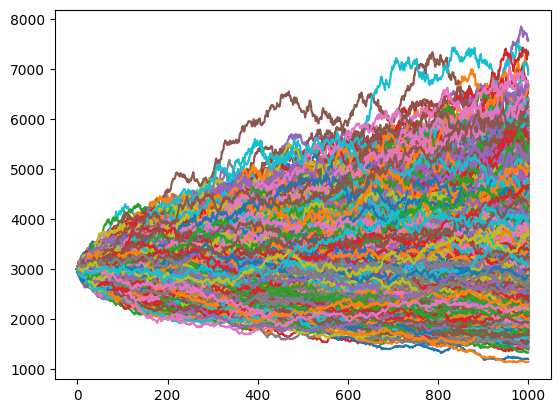

np.float64(26.708130163150003)

In [259]:
S0 = 2989.16
r = 0.0500
sigma = 0.19 #VDX volatility surface from Jun 25 expiry and 90% strike
T = 1.5288
K = 1070
barrier = 2391.33
Nt = 1000 #number of time itervals (lets get one for each day)
Nsim = 10000

paths = underlyingPriceSimulation(S0, r, sigma, T, Nt, Nsim)
plt.plot(paths.T)
plt.show()

price_1 = BarrierOptionPrice(S0, r, sigma, T, K, barrier, Nt, Nsim, type = 'down and out put')
price_1 

### Vanilla Put - Strike 1144.99

In [214]:
S0 = 2989.16  
K = 1070      
T = 1.5288
r = 0.0500
sigma = 0.19
ratio = 0.33454
S = S0*ratio

def black_scholes_put(S, K, T, r, sigma):
    d1 = (math.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * math.sqrt(T))
    d2 = d1 - sigma * math.sqrt(T)
    put_price = K * math.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)
    delta = norm.cdf(d1) - 1
    gamma = norm.pdf(d1) / (S * sigma * math.sqrt(T))
    vega = S * norm.pdf(d1) * math.sqrt(T)
    theta = (-S * norm.pdf(d1) * sigma / (2 * math.sqrt(T)) +
             r * K * math.exp(-r * T) * norm.cdf(-d2))
    rho = -K * T * math.exp(-r * T) * norm.cdf(-d2)

    return {
        "Price": put_price,
        "Delta": delta,
        "Gamma": gamma,
        "Vega": vega / 100,   # Per 1% change in vol
        "Theta": theta / 365, # Per day
        "Rho": rho / 100      # Per 1% change in rate
    }

put_price = black_scholes_put(S, K, T, r, sigma)
put_price

{'Price': np.float64(88.79370894882538),
 'Delta': np.float64(-0.4384837690861172),
 'Gamma': np.float64(0.0016779515959193807),
 'Vega': np.float64(4.873917040388822),
 'Theta': np.float64(-0.010747683619382912),
 'Rho': np.float64(-8.060975090374944)}

### ZCB present value 

In [262]:
r = 0.0500
T = 1.5288
price_ZCB = 1144.99*math.exp(-r*T)
price_ZCB

1060.7284651301932

## Pricing certificate ( replictating portfolio)

In [265]:
replicating_price = price_ZCB + price_1  - put_price['Price']
replicating_price

np.float64(998.6428863445177)

## Computing Greeks 

In [297]:
def MC_Delta(S0, r, sigma, T, K, barrier, Nt, Nsim, option_type, epsilon=0.01):
    price_up = BarrierOptionPrice(S0 + epsilon*S0, r, sigma, T, K, barrier, Nt, Nsim, option_type)
    price_down = BarrierOptionPrice(S0 - epsilon*S0, r, sigma, T, K, barrier, Nt, Nsim, option_type)
    return (price_up - price_down) / (2 * (epsilon*S0))

def MC_Gamma(S0, r, sigma, T, K, barrier, Nt, Nsim, option_type, epsilon=0.01):
    price_up = BarrierOptionPrice(S0 + epsilon*S0, r, sigma, T, K, barrier, Nt, Nsim, option_type)
    price_0 = BarrierOptionPrice(S0, r, sigma, T, K, barrier, Nt, Nsim, option_type)
    price_down = BarrierOptionPrice(S0 - epsilon*S0, r, sigma, T, K, barrier, Nt, Nsim, option_type)
    return (price_up - 2 * price_0 + price_down) / ((epsilon*S0) ** (1/2))

def MC_Vega(S0, r, sigma, T, K, barrier, Nt, Nsim, option_type, epsilon=0.01):
    price_up = BarrierOptionPrice(S0, r, sigma + sigma*epsilon, T, K, barrier, Nt, Nsim, option_type) 
    price_down = BarrierOptionPrice(S0, r, sigma - sigma*epsilon, T, K, barrier, Nt, Nsim, option_type) 
    return ((price_up - price_down) / (2 * (epsilon)))

def MC_Theta(S0, r, sigma, T, K, barrier, Nt, Nsim, option_type, epsilon=0.01):
    price_up = BarrierOptionPrice(S0, r, sigma, T + epsilon*T, K, barrier, Nt, Nsim, option_type)
    price_down = BarrierOptionPrice(S0, r, sigma, T - epsilon*T, K, barrier, Nt, Nsim, option_type)
    theta = (price_up - price_down) / (2 * epsilon*T)
    return -theta

def MC_Rho(S0, r, sigma, T, K, barrier, Nt, Nsim, option_type, epsilon=0.01):
    price_up = BarrierOptionPrice(S0, r + r*epsilon, sigma, T, K, barrier, Nt, Nsim, option_type) 
    price_down = BarrierOptionPrice(S0, r - r*epsilon, sigma, T, K, barrier, Nt, Nsim, option_type) 
    return (price_up - price_down) / (2 * epsilon)


### Down and out put

In [300]:
S0 = 2989.16
r = 0.0489
sigma = 0.19
T = 1.5068
K = 1070
barrier = 2391.33
Nt = 365 
Nsim = 10000
option_type = 'down and out put'  # or 'down and in put'

# Prices
price = BarrierOptionPrice(S0, r, sigma, T, K, barrier, Nt, Nsim, option_type)
delta = MC_Delta(S0, r, sigma, T, K, barrier, Nt, Nsim, option_type)
gamma = MC_Gamma(S0, r, sigma, T, K, barrier, Nt, Nsim, option_type)
vega = MC_Vega(S0, r, sigma, T, K, barrier, Nt, Nsim, option_type)
theta = MC_Theta(S0, r, sigma, T, K, barrier, Nt, Nsim, option_type)
rho = MC_Rho(S0, r, sigma, T, K, barrier, Nt, Nsim, option_type)

print(f"Price: {price:.4f}")
print(f"Delta: {delta:.4f}")
print(f"Gamma: {gamma:.4f}")
print(f"Vega: {vega:.4f}")
print(f"Theta: {theta:.4f}")
print(f"Rho: {rho:.4f}")


Price: 27.7621
Delta: -0.0130
Gamma: -0.0649
Vega: -36.5273
Theta: 50.1302
Rho: -23.1712


In [301]:
N_runs = 200
greeks = {
    "Price": [],
    "Delta": [],
    "Gamma": [],
    "Vega": [],
    "Theta": [],
    "Rho": []
}

for _ in range(N_runs):
    greeks["Price"].append(BarrierOptionPrice(S0, r, sigma, T, K, barrier, Nt, Nsim, option_type))
    greeks["Delta"].append(MC_Delta(S0, r, sigma, T, K, barrier, Nt, Nsim, option_type))
    greeks["Gamma"].append(MC_Gamma(S0, r, sigma, T, K, barrier, Nt, Nsim, option_type))
    greeks["Vega"].append(MC_Vega(S0, r, sigma, T, K, barrier, Nt, Nsim, option_type))
    greeks["Theta"].append(MC_Theta(S0, r, sigma, T, K, barrier, Nt, Nsim, option_type))
    greeks["Rho"].append(MC_Rho(S0, r, sigma, T, K, barrier, Nt, Nsim, option_type))

# Take averages
avg_greeks = {k: np.mean(v) for k, v in greeks.items()}

# Print results
for greek, value in avg_greeks.items():
    print(f"{greek}: {value:.4f}")


Price: 28.0417
Delta: -0.0003
Gamma: -0.0735
Vega: -37.6671
Theta: 16.2895
Rho: -2.9047
